# US Participation, Employment to Population, Unemployment, and Unfilled Vacancies to Population Rates
In this notebook I look at the total population of the US that works or is capable of working. It's referred to as _Population Level_. It is defined as: "_Persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces._"

I then look at the different ratios where the population level is in the denominator:
1. **Participation Rate**: The percentage of the population level that work or are actively looking for work.
2. **Employment/Population Rate**: The percentage of the population level that work.
3. **Unemployment Rate**: The percentage of the population level that are actively looking for work.
4. **Unfilled Vacancies/Population Rate**: The number of unfilled vacancies as percentage of the population level.
and how they've evolved from 1948.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1948-01-01')
report_end = date.today()

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org):
* `CNP16OV` &mdash; Population Level, thousands of persons (monthly frequency). Civilian noninstitutional population is defined as persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.
* `CLF16OV` &mdash; Civilian Labor Force Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are either working or actively looking for work.
* `CE16OV` &mdash; Employment Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are working.
* `LMJVTTUVUSM647S` &mdash; Total Unfilled Job Vacancies for the United States, seasonally adjusted (monthly frequency).

The rest is derived from these dataseries.

In [3]:
MEAN_LEVEL_OF = 'Mean level of '
PARTICIPATION_RATE = 'Participation Rate'
MEAN_PARTICIPATION_RATE = MEAN_LEVEL_OF + PARTICIPATION_RATE
EMPLOYMENT_POPULATION_RATE = 'Employment/Population Rate'
MEAN_EMPLOYMENT_POPULATION_RATE = MEAN_LEVEL_OF + EMPLOYMENT_POPULATION_RATE
UNEMPLOYMENT_RATE = 'Unemployment Rate'
MEAN_UNEMPLOYMENT_RATE = MEAN_LEVEL_OF + UNEMPLOYMENT_RATE
UNFILLED_VACANCIES_POPULATION_RATE = 'Unfilled Vacancies/Population Rate'
MEAN_UNFILLED_VACANCIES_POPULATION_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_POPULATION_RATE
UNFILLED_VACANCIES_LABOR_FORCE_RATE = 'Unfilled Vacancies/Labor Force Rate'
MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_LABOR_FORCE_RATE
UNEMPLOYMENT_RATIOS_GRAPH_TITLE = 'US Participation, Employment/Population, Unemployment, and Unfilled Vacancies/Population Rates'
UNEMPLOYMENT_RATIOS_SUBSET_1_GRAPH_TITLE = 'US Participation and Employment/Population Rates'
UNEMPLOYMENT_RATIOS_SUBSET_2_GRAPH_TITLE = 'US Unemployment, Unfilled Vacancies/Population and Unfilled Vacancies/Labor Force Rates'
CORRELATION_FFR_PR_GRAPH_TITLE = 'Correlation between annual changes in Fed Funds and Participation Rates'
CORRELATION_FFR_UR_GRAPH_TITLE = 'Correlation between annual changes in Fed Funds and Unemployment Rates'
ANNUAL_PERCENTAGE_CHANGES = ' Annual Percantage Changes'

In [4]:
data = web.get_data_fred(['CNP16OV', 'CLF16OV', 'CE16OV', 'LMJVTTUVUSM647S'], report_start, report_end)

data.LMJVTTUVUSM647S /= 1000 # Converting to thousands of persons
data[PARTICIPATION_RATE] = data.CLF16OV / data.CNP16OV
data[EMPLOYMENT_POPULATION_RATE] = data.CE16OV / data.CNP16OV
data[UNEMPLOYMENT_RATE] = (data.CLF16OV - data.CE16OV) / data.CLF16OV
data[UNFILLED_VACANCIES_POPULATION_RATE] = data.LMJVTTUVUSM647S / data.CNP16OV
data[UNFILLED_VACANCIES_LABOR_FORCE_RATE] = data.LMJVTTUVUSM647S / data.CLF16OV

In [5]:
data.tail()

,CNP16OV,CLF16OV,CE16OV,LMJVTTUVUSM647S,Participation Rate,Employment/Population Rate,Unemployment Rate,Unfilled Vacancies/Population Rate,Unfilled Vacancies/Labor Force Rate
DATE,,,,,,,,,
2022-05-01,263679,164376,158426,11303.0,0.623394,0.600829,0.036197,0.042867,0.068763
2022-06-01,263835,164023,158111,11040.0,0.621688,0.599280,0.036044,0.041844,0.067308
2022-07-01,264012,163960,158290,11239.0,0.621032,0.599556,0.034582,0.042570,0.068547
2022-08-01,264184,164746,158732,NaN,0.623603,0.600839,0.036505,NaN,NaN
2022-09-01,264356,164689,158936,NaN,0.622982,0.601220,0.034933,NaN,NaN


### Visualizing the data
Looking at the last datapoints, one can see that while unemployment rate has declined to the pre-COVID levels, two other important indicators haven't yet recovered to the pre-pandemic levels:
1. The participation rate (the number of people that work or are actively looking for work as percentage of the population level) is at 62.10% now while it was at 63.39% in Feb 2020.
2. The unfilled vacancies to population rate (the number of unfilled vacancies as percentage of the population level) is at 4.3% while it was at 2.7% in Feb 2020.

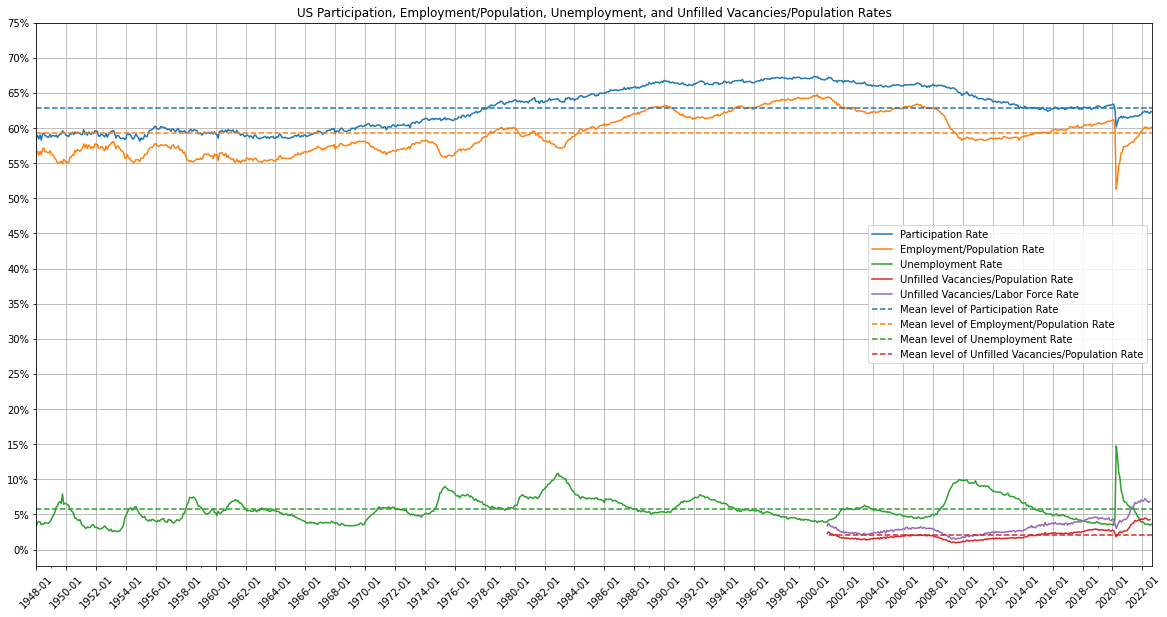

In [6]:
ax = data.iloc[:,4:].plot(figsize=(20,10), grid=True, title=UNEMPLOYMENT_RATIOS_GRAPH_TITLE,
                          xticks=data.index[::24], xlabel='', rot=45, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.axhline(y=data.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
non_nan_to_total_len = data.iloc[:,7].count() / len(data.iloc[:,7])
ax.axhline(y=data.iloc[:,7].mean(), xmin=1-non_nan_to_total_len, ls='--', c='#d62728',
           label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data.index[::24])))

### Zooming in on 2001 and later

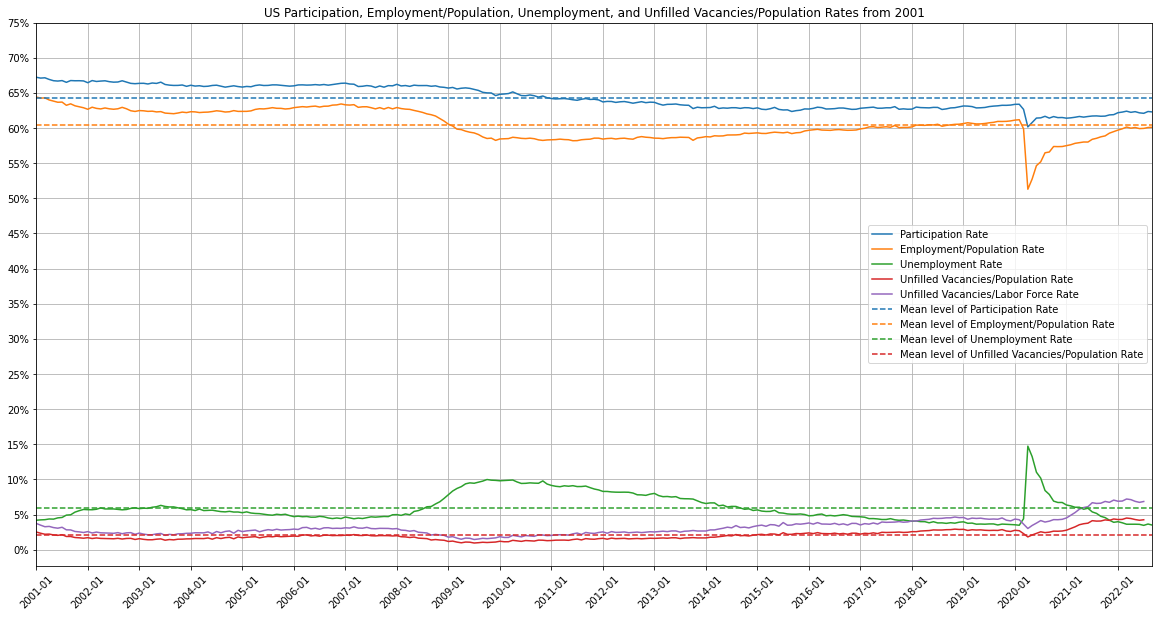

In [7]:
data_short = data.loc['2001':]
ax = data_short.iloc[:,4:].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data_short.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.axhline(y=data_short.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
ax.axhline(y=data_short.iloc[:,7].mean(), ls='--', c='#d62728', label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data_short.index[::12])))

#### Participation and Employment to Population Rates

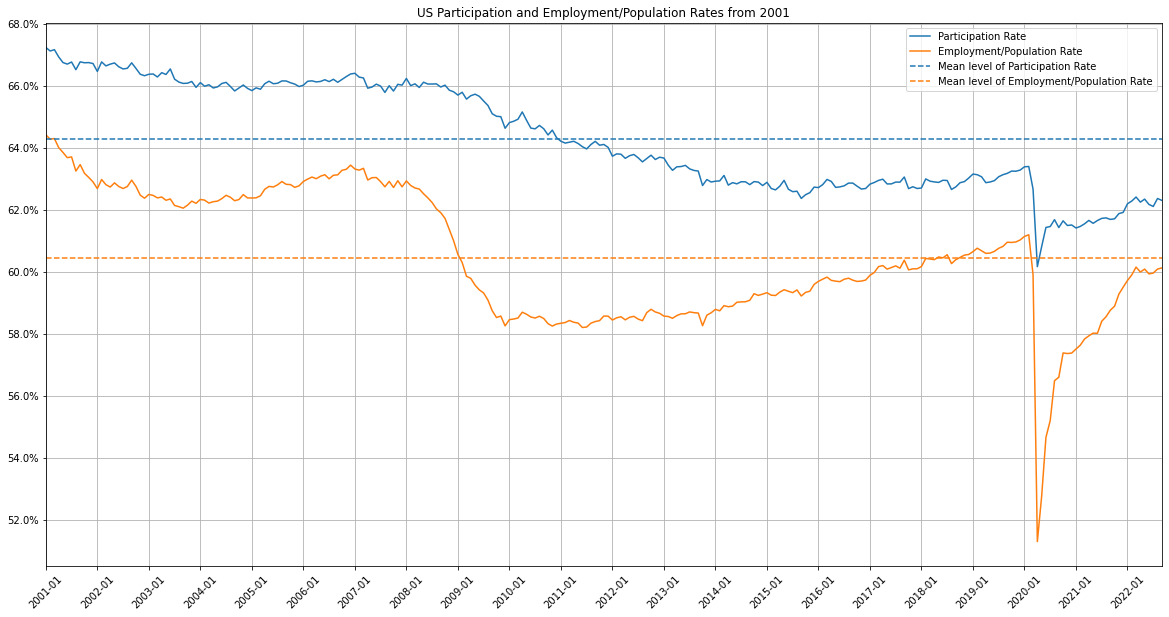

In [8]:
ax = data_short.iloc[:,4:6].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_1_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data_short.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data_short.index[::12])))

In [9]:
SINCE = ' since %s: ' % data_short.index[0].date().strftime('%Y-%m')
print(MEAN_PARTICIPATION_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,4].mean()*100))
print(MEAN_EMPLOYMENT_POPULATION_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,5].mean()*100))

Mean level of Participation Rate since 2001-01: 64.2901%
Mean level of Employment/Population Rate since 2001-01: 60.4528%


In [10]:
pd.options.display.float_format = '{:.4%}'.format
data_short.iloc[:,4:6]

,Participation Rate,Employment/Population Rate
DATE,,
2001-01-01,67.2314%,64.4160%
2001-02-01,67.1155%,64.2716%
2001-03-01,67.1585%,64.2929%
2001-04-01,66.9241%,64.0014%
2001-05-01,66.7427%,63.8433%
...,...,...
2022-05-01,62.3394%,60.0829%
2022-06-01,62.1688%,59.9280%
2022-07-01,62.1032%,59.9556%


#### Uneployment,  Unfilled Vacancies to Population, and Unfilled Vacancies to Labor Force rates
Both unfilled vacancies to population and unfilled facancies to labor force ratios show that labor demand is still unusually high by historical levels, which makes it likely that the FOMC will continue rasing rates given [the current levels of CPI and Wage Inflation](./M2_PCE_and_CPI.ipynb).

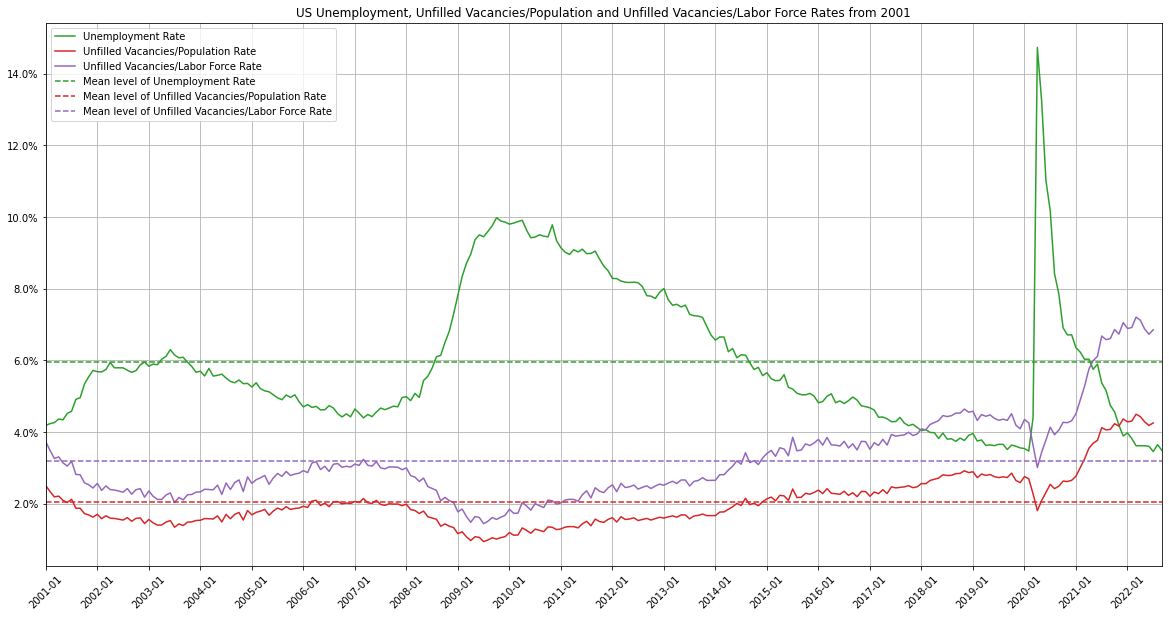

In [11]:
ax = data_short.iloc[:,6:].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_2_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45,
                                color=['#2ca02c', '#d62728', '#9467bd'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
ax.axhline(y=data_short.iloc[:,7].mean(), ls='--', c='#d62728', label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.axhline(y=data_short.iloc[:,8].mean(), ls='--', c='#9467bd', label=MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data_short.index[::12])))

In [12]:
print(MEAN_UNEMPLOYMENT_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,6].mean()*100))
print(MEAN_UNFILLED_VACANCIES_POPULATION_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,7].mean()*100))
print(MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,8].mean()*100))

Mean level of Unemployment Rate since 2001-01: 5.9701%
Mean level of Unfilled Vacancies/Population Rate since 2001-01: 2.0498%
Mean level of Unfilled Vacancies/Labor Force Rate since 2001-01: 3.2076%


In [13]:
data_short.iloc[:,6:]

,Unemployment Rate,Unfilled Vacancies/Population Rate,Unfilled Vacancies/Labor Force Rate
DATE,,,
2001-01-01,4.1878%,2.5069%,3.7288%
2001-02-01,4.2373%,2.3390%,3.4850%
2001-03-01,4.2668%,2.1922%,3.2642%
2001-04-01,4.3672%,2.2151%,3.3099%
2001-05-01,4.3442%,2.0970%,3.1420%
...,...,...,...
2022-05-01,3.6197%,4.2867%,6.8763%
2022-06-01,3.6044%,4.1844%,6.7308%
2022-07-01,3.4582%,4.2570%,6.8547%


### Do increases in the Fed Funds Rate correlate with increases in the Participation or Unemployment rates?
It's interesting to see if tightening monetaring policy correlates with increases in the participation or unemployment rates. In the below analysis I look at annual percentage changes. 

Additional series used:
* FEDFUNDS &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)

In [14]:
pct_change_particip_rate = data.iloc[:,4].pct_change(12).loc['1956':]
pct_change_unempl_rate = data.iloc[:,6].pct_change(12).loc['1956':]
pct_change_ffr = web.get_data_fred('FEDFUNDS', start=report_start, end=report_end)
pct_change_ffr = pct_change_ffr.iloc[:, 0].pct_change(12).loc['1956':] 

In [15]:
pct_change_ffr_prtr = pd.concat([pct_change_ffr, pct_change_particip_rate, pct_change_unempl_rate], axis=1).loc['2000':]

# For better visualization
means = pct_change_ffr_prtr.mean()
pct_change_ffr_prtr.iloc[:, 0] /= 100
pct_change_ffr_prtr.iloc[:, 2] /= 10

pct_change_ffr_prtr.rename(
    columns={'FEDFUNDS': 'Fed Funds Annual Percentage Changes / 100', 
             PARTICIPATION_RATE: PARTICIPATION_RATE + ANNUAL_PERCENTAGE_CHANGES,
             UNEMPLOYMENT_RATE: UNEMPLOYMENT_RATE + ANNUAL_PERCENTAGE_CHANGES + ' / 10'},
    inplace=True)

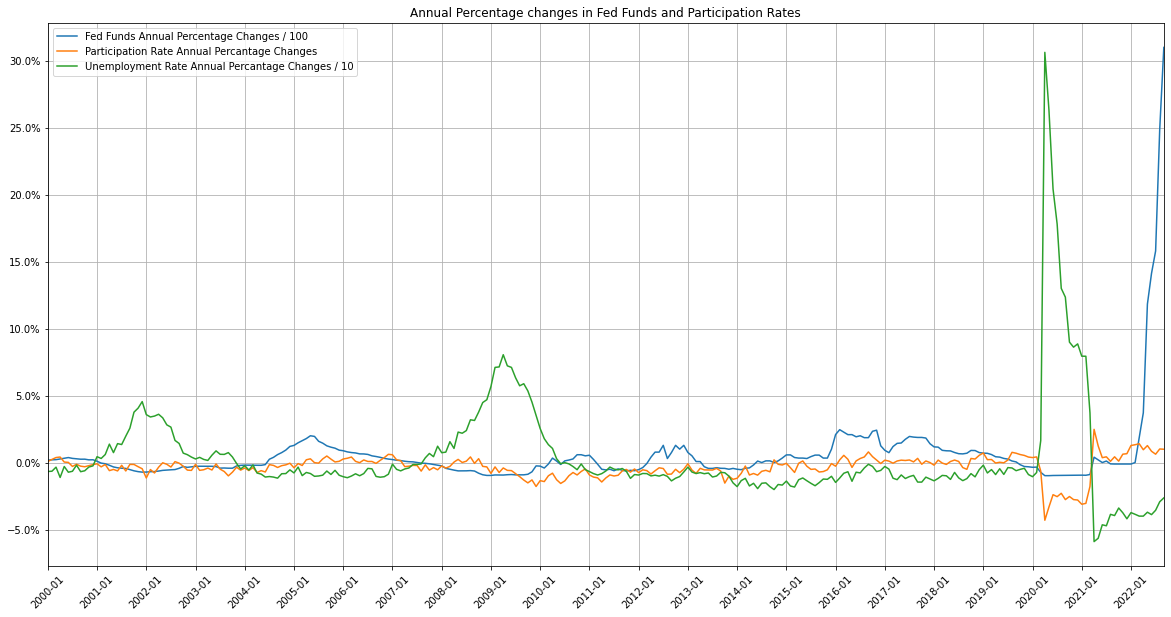

In [16]:
ax = pct_change_ffr_prtr.plot(figsize=(20,10), grid=True,
                              title='Annual Percentage changes in Fed Funds and Participation Rates',
                              xticks=pct_change_ffr_prtr.index[::12], xlabel='', rot=45)#, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), pct_change_ffr_prtr.index[::12])))

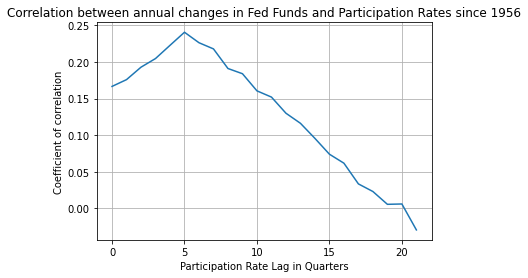

In [17]:
idx = pd.Index(range(22), name='Participation Rate Lag in Quarters')
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.corr(pct_change_particip_rate.shift(-lag))), index=idx)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_PR_GRAPH_TITLE + ' since 1956',
                                       ylabel='Coefficient of correlation')

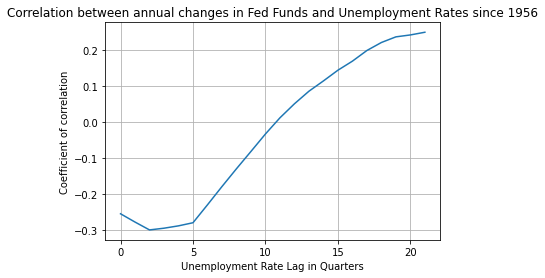

In [18]:
idx2 = pd.Index(range(22), name='Unemployment Rate Lag in Quarters')
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.corr(pct_change_unempl_rate.shift(-lag))), index=idx2)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_UR_GRAPH_TITLE + ' since 1956',
                                       ylabel='Coefficient of correlation')

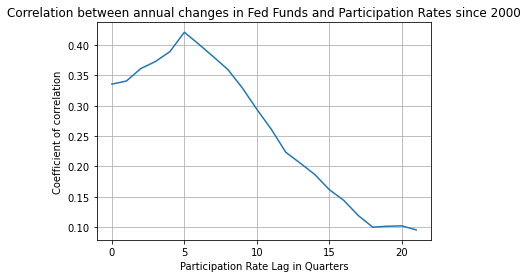

In [19]:
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.loc['2000':].corr(pct_change_particip_rate.loc['2000':].shift(-lag))), index=idx,)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_PR_GRAPH_TITLE + ' since 2000',
                                       ylabel='Coefficient of correlation')

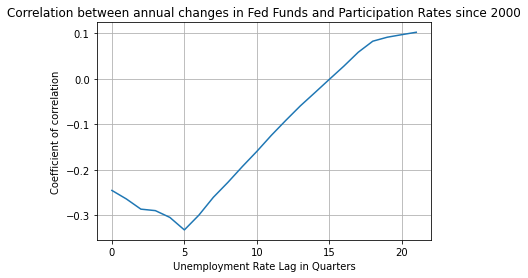

In [20]:
effect_of_monetary_tightening = pd.Series(idx2.map(lambda lag: pct_change_ffr.loc['2000':].corr(pct_change_unempl_rate.loc['2000':].shift(-lag))), index=idx2)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_PR_GRAPH_TITLE + ' since 2000',
                                       ylabel='Coefficient of correlation')

#### Conclusions
* **Fed Funds and Participation Rates**: There's a modest correlation between increases in Fed Funds and Participation rates when we look at the data since 1956. It gets even more pronounced if we look at the correlations between the two in this century. In both cases the correlation gets slightly higher with a lag of 3-4 quarters in the participation rate.
* **Fed Funds and Unemployment Rates**: Surprisingly a negative correlation, unlikely indicative of a causality.